<a href="https://colab.research.google.com/github/Bikash3/CNNWasteSegregation/blob/main/CNN_Waste_Segregation_Bikash_Sarkar1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [1]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [2]:
# Import essential libraries
import os
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import sklearn
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load and unzip the dataset
dataPath = '/content/drive/MyDrive/Upgrad/CNN_Waste_Segregation/data.zip'
zip_object = zipfile.ZipFile(file=dataPath, mode='r')
zip_object.extractall('./sample_data')
zip_object.close()

## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [6]:
# Create a function to load the raw images
# function is creating dataset out of images in directory, normalizing the data and resizing it
def load_and_prepare_data(data_dir, target_size, batch_size):
    # Create a dataset from the image directory
    dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='int',
        image_size=target_size, # You can adjust this if needed
        interpolation='nearest',
        batch_size=batch_size,
        shuffle=True
    )

    # Get the class names
    class_names = dataset.class_names

    # Convert images to RGB and normalize
    def preprocess(image, label):
        image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
        return image, label

    dataset = dataset.map(preprocess)

    return dataset, class_names

# Function to plot sample images
def plot_sample_images(images, labels, class_names, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i]* 255)
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [7]:
# Get the images and their labels
data_dir = '/content/sample_data/data'
batch_size = 32
target_size = (128, 128)
dataset, class_names = load_and_prepare_data(data_dir, target_size, batch_size)

Found 7625 files belonging to 7 classes.


In [8]:
# Convert the dataset to lists of images and labels
image_list = []
label_list = []
for images, labels in dataset:
    # Convert TensorFlow tensors to NumPy arrays and extend the lists
    image_list.extend(images.numpy())
    label_list.extend(labels.numpy())
# Create a DataFrame from the NumPy arrays
data_dict = {'images': image_list, 'labels': label_list}
img_df = pd.DataFrame(data_dict)

Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

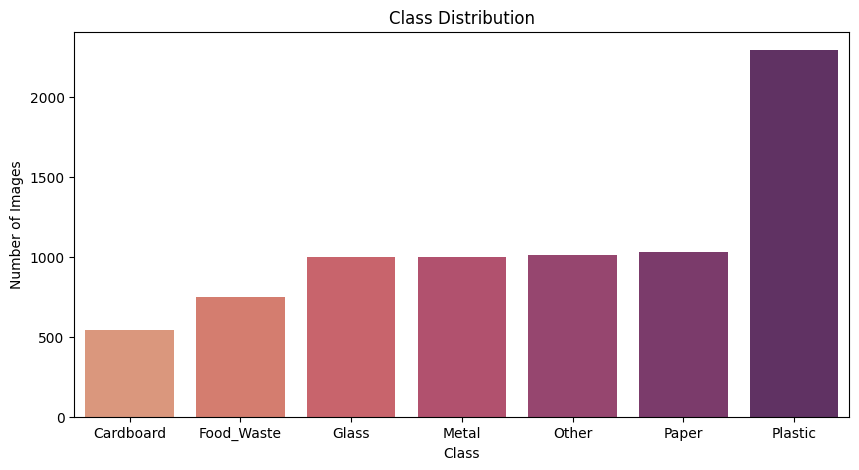

In [9]:
# Visualise Data Distribution
class_counts = list(img_df['labels'].value_counts().sort_values(ascending=True))
plt.figure(figsize=(10, 5))
sns.barplot(x=class_names, y=class_counts, palette='flare')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

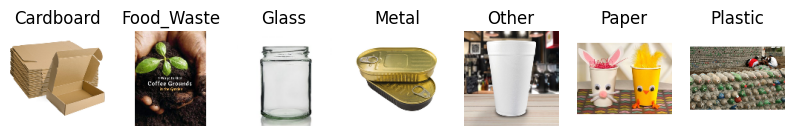

In [10]:
# Visualise Sample Images (across different labels)
img_df_sample = img_df.groupby('labels').apply(lambda x: x.sample(1)).reset_index(drop=True)
plot_sample_images(img_df_sample['images'], img_df_sample['labels'], class_names, num_images=7)

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [11]:
# Find the smallest and largest image dimensions from the data set
min_width = min(img.shape[1] for img in image_list)
min_height = min(img.shape[0] for img in image_list)
max_width = max(img.shape[1] for img in image_list)
max_height = max(img.shape[0] for img in image_list)
print(f"Smallest width: {min_width}, Smallest height: {min_height}")
print(f"Largest width: {max_width}, Largest height: {max_height}")

Smallest width: 128, Smallest height: 128
Largest width: 128, Largest height: 128


In [12]:
# Resize the image dimensions
img_df['images'][0].shape

(128, 128, 3)

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [13]:
# Encode the labels suitably
img_df['labels'].value_counts()

,count
labels,
6,2295
5,1030
4,1010
3,1000
1,1000
2,750
0,540


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [14]:
# Assign specified parts of the dataset to train and validation sets
X = np.array(img_df['images'].tolist())
y = np.array(img_df['labels'].tolist())
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=42, stratify=y)

In [15]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (5337, 128, 128, 3)
y_train shape: (5337,)
x_test shape: (2288, 128, 128, 3)
y_test shape: (2288,)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [55]:
# Build and compile the model
input_shape = x_train.shape[1:]
model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [56]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,146,343 (4.37 MB)

 Trainable params: 1,145,895 (4.37 MB)

 Non-trainable params: 448 (1.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [27]:
# --- Callbacks for improved training ---
# Early Stopping: Stop training when validation loss doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model Checkpoint: Save the best model based on validation accuracy
model_checkpoint = ModelCheckpoint('best_waste_model.keras', monitor='val_accuracy', save_best_only=True)

# Reduce Learning Rate on Plateau: Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

In [54]:
# Training
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.2420 - loss: 2.5738 - val_accuracy: 0.0983 - val_loss: 2.4444 - learning_rate: 0.0010
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.3152 - loss: 1.8132 - val_accuracy: 0.0983 - val_loss: 2.8148 - learning_rate: 0.0010
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3166 - loss: 1.7416 - val_accuracy: 0.1626 - val_loss: 2.1051 - learning_rate: 0.0010
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.3287 - loss: 1.7191 - val_accuracy: 0.3230 - val_loss: 1.7099 - learning_rate: 0.0010
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.3180 - loss: 1.7121 - val_accuracy: 0.3256 - val_loss: 1.6590 - learning_rate: 0.0010
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.3359 - loss: 1.6576 - val_accuracy: 0.3243 - val_loss: 1.7045 - learning_rate: 0.0010
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.3261 - los

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


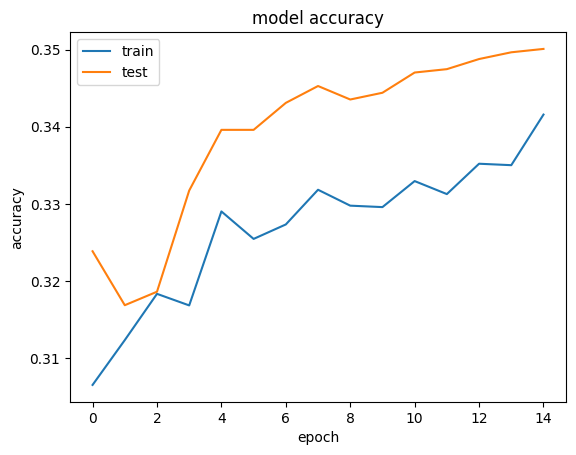

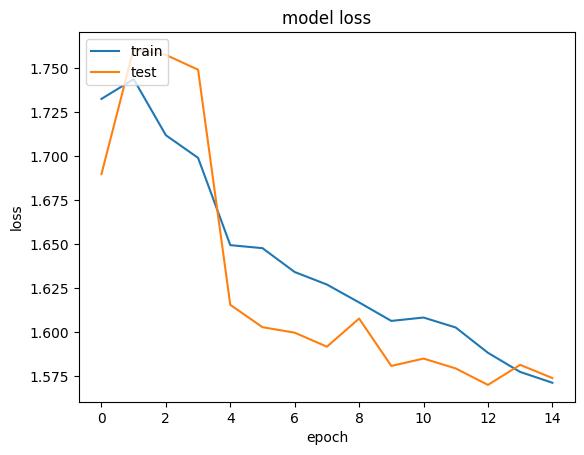

In [40]:
# Evaluate on the test set; display suitable metrics
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [21]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [22]:
# Create a function to augment the images




In [23]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [24]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results